In [12]:
import os
import random 
import math

from functools import partial # fix some parameters of a function and generate a new function
from tqdm.notebook import tqdm

import torch
import numpy as np
import matplotlib.pyplot as plt

# utility torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

try: 
    import pytorch_lightning as pl
except ModuleNotFoundError:
    %pip install --quiet pytorch-lightning
    import pytorch_lightning as pl
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint

In [2]:
pl.seed_everything(42)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Seed set to 42


In [3]:
def scaled_dot_product(q_vect, k_vect, v_vect, mask=None):
    dim_key_vect = k_vect.size()[-1]
    attention_logits = torch.matmul(q_vect, k_vect.transpose(-2, -1)) / math.sqrt(dim_key_vect)
    if mask is not None:
        attention_logits = attention_logits.masked_fill(mask == 0, -9e15)
    
    attention_weights = F.softmax(attention_logits, dim=-1)
    values = torch.matmul(attention_weights, v_vect)
    return values, attention_weights


In [4]:
seq_len, dim_k = 3, 30
Q_mat = torch.rand((seq_len, dim_k))
K_mat = torch.rand((seq_len, dim_k))
V_mat = torch.rand((seq_len, dim_k))
values, attention = scaled_dot_product(Q_mat, K_mat, V_mat)


In [5]:
V_mat, values

(tensor([[0.6161, 0.7583, 0.5907, 0.3219, 0.7610, 0.7628, 0.6870, 0.4121, 0.3676,
          0.5535, 0.4117, 0.3510, 0.8196, 0.9297, 0.4505, 0.3881, 0.5073, 0.4701,
          0.6202, 0.6401, 0.0459, 0.3155, 0.9211, 0.6948, 0.4751, 0.1985, 0.1941,
          0.0521, 0.3370, 0.6689],
         [0.8188, 0.7308, 0.0580, 0.1993, 0.4211, 0.9837, 0.5723, 0.3705, 0.7069,
          0.3096, 0.1764, 0.8649, 0.2726, 0.3998, 0.0026, 0.8346, 0.8788, 0.6822,
          0.1514, 0.0065, 0.0939, 0.8729, 0.7401, 0.9208, 0.7619, 0.6265, 0.4951,
          0.1197, 0.0716, 0.0323],
         [0.7047, 0.2545, 0.3994, 0.2122, 0.4089, 0.1481, 0.1733, 0.6659, 0.3514,
          0.8087, 0.3396, 0.1332, 0.4118, 0.2576, 0.3470, 0.0240, 0.7797, 0.1519,
          0.7513, 0.7269, 0.8572, 0.1165, 0.8596, 0.2636, 0.6855, 0.9696, 0.4295,
          0.4961, 0.3849, 0.0825]]),
 tensor([[0.7166, 0.5460, 0.3434, 0.2385, 0.5103, 0.5850, 0.4429, 0.5013, 0.4694,
          0.5787, 0.3074, 0.4271, 0.4803, 0.4891, 0.2657, 0.3836, 0.7359,

In [6]:
# X = batch * seq_len * dim_hidden_state 

# Helper function to support different mask shapes.
# Output shape supports (batch_size, number of heads, seq length, seq length)
# If 2D: broadcasted over batch size and number of heads
# If 3D: broadcasted over number of heads
# If 4D: leave as is

def expand_mask(mask):
    assert mask.ndim >= 2, "Mask must be at least 2-dimensional with seq_length x seq_length"
    if mask.ndim == 3:
        mask = mask.unsqueeze(1)
    while mask.ndim < 4:
        mask = mask.unsqueeze(0)
    return mask


class MultiHead(nn.Module):

    def __init__(self, input_dim, hidden_dim, num_heads):
        super(MultiHead, self).__init__()

        assert hidden_dim % num_heads == 0, "latent dimension must be divisible by the number of heads"

        self.num_heads = num_heads
        self.embedding_dim = hidden_dim
        self.input_dim = input_dim
        self.dim_head = hidden_dim // num_heads

        self.qkv_projection = nn.Linear(input_dim, 3 * hidden_dim)
        self.my_projection = nn.Linear(hidden_dim, hidden_dim)

        self._reset_parameters()
    
    def _reset_parameters(self):
        nn.init.xavier_uniform_(self.qkv_projection.weight)
        self.qkv_projection.bias.data.fill_(0)
        
        nn.init.xavier_uniform_(self.my_projection.weight)
        self.my_projection.bias.data.fill_(0)
    
    def forward(self, x, mask=None, return_attention=False):
        batch_size, seq_len, _ = x.size()

        if mask is not None:
            mask = expand_mask(mask)
        
        qkv = self.qkv_projection(x)
        qkv = qkv.reshape(batch_size, seq_len, self.num_heads, 3 * self.dim_head)
        q, k, v = qkv.chunk(3, dim=-1)
        
        values, attention = scaled_dot_product(q, k, v, mask)
        values = values.permute(0, 2, 1, 3) # batch, seq_len, num_heads, self.embedding_dim
        values = values.reshape(batch_size, seq_len, self.embedding_dim)

        if return_attention:
            return self.my_projection(values), attention
        return self.my_projection(values)
    

In [7]:
class Encoder(nn.Module):

    def __init__(self, input_dim, num_heads, dim_feedforwards, dropout=0.0):
        super(Encoder, self).__init__()

        self.multi_head = MultiHead(input_dim, input_dim, num_heads)
        self.feedforward = nn.Sequential(
            nn.Linear(input_dim, dim_feedforwards),
            nn.Dropout(dropout),
            nn.ReLU(inplace=True),
            nn.Linear(dim_feedforwards, input_dim),
        )
        self.norm1 = nn.LayerNorm(input_dim)
        self.norm2 = nn.LayerNorm(input_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask=None):
        
        _, values = self.multi_head(x, mask)
        x = x + self.dropout(values) # residual connection
        x = self.norm1(x)

        lin_output = self.feedforward(x)
        x = x + self.dropout(lin_output)
        x = self.norm2(x)
        return x
    


In [8]:
class PositionalEmbedding(nn.Module):

    def __init__(self, input_dim, max_seq_len=512):
        super(PositionalEmbedding, self).__init__()

        embedd = torch.zeros(max_seq_len, input_dim)
        position = torch.arange(0, max_seq_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, input_dim, 2).float() * (-math.log(10000.0) / input_dim))
        embedd[:, 0::2] = torch.sin(position * div_term)
        embedd[:, 1::2] = torch.cos(position * div_term)
        embedd = embedd.unsqueeze(0)

        self.register_buffer('embedding', embedd)

        #self.token_embedding = nn.Linear(input_dim, input_dim)
        #self.position_embedding = nn.Parameter(torch.randn(max_position, 1, input_dim))
        #self.dropout = nn.Dropout(0.1)

    def forward(self, x):
        return x + self.embedding[:, :x.size(1)]
    


class Transformer(nn.Module):

    def __init__(self, num_layers, input_dim, num_heads, dim_feedforwards, dropout):
        super(Transformer, self).__init__()

        self.encoder = nn.ModuleList([
            Encoder(input_dim, num_heads, dim_feedforwards, dropout) for _ in range(num_layers)
        ])
    
    def forward(self, x, mask=None):
        for layer in self.encoder:
            x = layer(x, mask)
        return x
    
    def get_attention_map(self, x, mask=None):
        attention_maps = []
        for layer in self.encoder:
            _, attention = layer(x, mask, return_attention=True)
            attention_maps.append(attention)
        return _, attention_maps

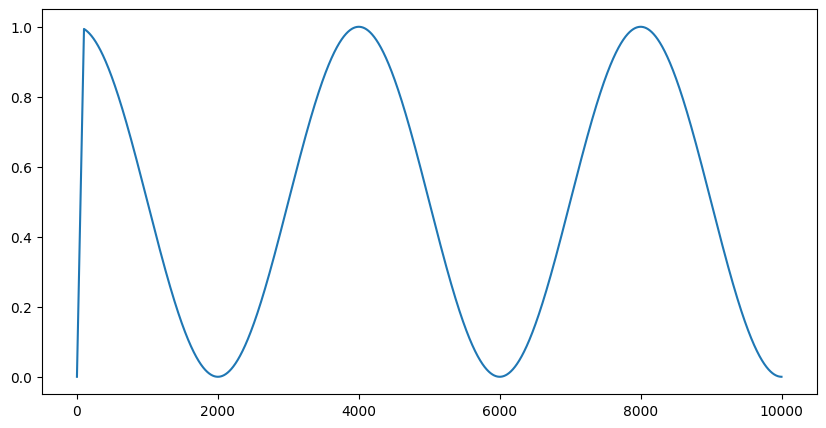

In [9]:
class WarmupScheduler(torch.optim.lr_scheduler._LRScheduler):

    def __init__(self, optimizer, warmup, max_number_iters=-1):
        self.warmup = warmup
        self.max_number_iters = max_number_iters
        super(WarmupScheduler, self).__init__(optimizer)


    def get_lr(self):
        lr_factor = self.get_lr_factor(epoch=self.last_epoch)
        return [base_lr * lr_factor for base_lr in self.base_lrs]
    
    def get_lr_factor(self, epoch):
        lr_factor = 0.5 * (1 + np.cos(np.pi * epoch  / self.max_number_iters))
        if epoch < self.warmup:
            lr_factor *= epoch / self.warmup
        return lr_factor
    

p = nn.Parameter(torch.randn(1, 3, 4))
optimizer = torch.optim.Adam([p], lr=1e-3)
lr_scheduler = WarmupScheduler(optimizer, warmup=100, max_number_iters=2000)

epochs = list(range(10000))
plt.figure(figsize=(10, 5))
plt.plot(epochs, [lr_scheduler.get_lr_factor(epoch) for epoch in epochs])    



In [10]:

import torch.optim as optim


In [13]:
class TransformerArc(nn.Module):
    
        def __init__(self,
                     input_dim,
                     hidden_dim,
                     max_seq_len,
                     num_heads,
                     dim_feedforwards,  
                     num_layers, 
                     output_dim, 
                     dropout=0.1,
                     num_classes=2,
                     ):
            
            super(TransformerArc, self).__init__()
    
            self.input_net = nn.Sequential(
                nn.Dropout(dropout),
                nn.Linear(input_dim, hidden_dim),            
            )
            
            self.positional_embedding = PositionalEmbedding(hidden_dim, max_seq_len=max_seq_len)
            self.transformer = Transformer(num_layers, input_dim, num_heads, dim_feedforwards, dropout)
            self.output_net = nn.Sequential(
                nn.Linear(hidden_dim, output_dim),
                nn.LayerNorm(output_dim), 
                nn.Dropout(dropout),    
                nn.Linear(output_dim,num_classes),
            )
        
       
        def forward(self, x, mask=None):
            x = self.input_net(x)
            x = self.positional_embedding(x)
            x = self.transformer(x, mask)
            x = self.output_net(x)
            return x

In [11]:
class TransformerArchitecture(pl.LightningModule):

    def __init__(self):
        super(TransformerArchitecture, self).__init__()


        input_dim = 16
        hidden_dim = 256
        max_seq_len = 1000
        num_heads = 8
        dim_feedforwards = 512
        num_layers = 2
        output_dim = 256

        # training parameters:
        self.lr = 1e-3
        self.warmup = 0.01
        self.max_iters = 10000
        self.device = torch.device.device("cuda:0" if torch.cuda.is_available() else "cpu")

        self.net = TransformerArc(input_dim,
                                  hidden_dim,
                                  max_seq_len,
                                  num_heads,
                                  dim_feedforwards,  
                                  num_layers, 
                                  output_dim, 
                                  dropout=0.1,
        )
    def forward(self, x, mask=None):
        return self.net(x, mask)


    @torch.no_grad()
    def get_attention_maps(self, x, mask=None, add_positional_encoding=True):
        """
        Function for extracting the attention matrices of the whole Transformer for a single batch.
        Input arguments same as the forward pass.
        """
        x = self.input_net(x)
        if add_positional_encoding:
            x = self.positional_encoding(x)
        attention_maps = self.transformer.get_attention_maps(x, mask=mask)
        return attention_maps

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=self.lr)

        # Apply lr scheduler per step
        lr_scheduler = WarmupScheduler(optimizer,
                                             warmup=self.warmup,
                                             max_iters=self.max_iters)
        return [optimizer], [{'scheduler': lr_scheduler, 'interval': 'step'}]

    def training_step(self, batch, batch_idx):
        inputs, labels = batch
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = self.gatr(inputs)

        probabilities = self.sigmoid(outputs)
        train_loss = self.criterion(probabilities,labels.float())
        train_accuracy = self.accuracy_meter(probabilities,labels.float())

        values = {"train_loss": train_loss, "train_acc": train_accuracy}
        self.log_dict(values, prog_bar = True)

        return train_loss
    
    def validation_step(self, batch, batch_idx):

        inputs, labels = batch
        inputs, labels = inputs.to(device),labels.to(device)
        outputs = self.gatr(inputs)

        probabilities = self.sigmoid(outputs)
        val_loss = self.criterion(probabilities,labels.float())
        val_accuracy = self.accuracy_meter(probabilities,labels.float())

        values = {"val_loss": val_loss, "val_acc": val_accuracy}
        self.log_dict(values, prog_bar = True)

        return val_loss
    
    def test_step(self, batch, batch_idx):
        inputs, labels = batch
        inputs, labels = inputs.to(self.device), labels.to(self.device)
        outputs = self.gatr(inputs)

        probabilities = self.sigmoid(outputs)
        test_loss = self.criterion(probabilities,labels.float())
        test_accuracy = self.accuracy_meter(probabilities,labels.float())

        values = {"test_loss": test_loss, "test_acc": test_accuracy}
        self.log_dict(values, prog_bar = True)

        return test_loss